# Implementation

In [ ]:
#| default_exp impl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| exports
from typing import Tuple
import torch, torch.utils.data, torch.nn as nn, torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageNet
from torchvision.models import vgg16, VGG16_Weights, vgg11, VGG11_Weights, alexnet, AlexNet_Weights
from lovely_tensors import monkey_patch
from torchinfo import summary

In [ ]:
#| exports
monkey_patch()

### Load some images

In [ ]:
#| exports
in_stats = ( (0.485, 0.456, 0.406),     # mean 
             (0.229, 0.224, 0.225) )    # std

tfms = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=in_stats[0], std=in_stats[1])
    ])

train = ImageNet(root="~/work/datasets/ImageNet", split="train", transform=tfms)
val = ImageNet(root="~/work/datasets/ImageNet", split="val", transform=tfms)

Label: 0 Image: tensor[3, 224, 224] n=150528 x∈[-2.101, 2.640] μ=0.125 σ=1.512


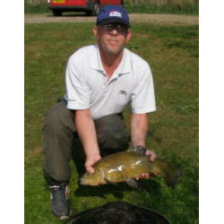

In [ ]:
#| exports
image, label = train[0]

print(f"Label: {label} Image: {image}")
image.rgb(denorm=in_stats)

Confirm it works. The image belongs to class `0` - `tench` (a fish species)

In [ ]:
(alexnet(weights=AlexNet_Weights.DEFAULT)
    .requires_grad_(False)
    .eval()(image[None])[0].argmax().item()
)

0

### Load and hook into AlexNet


- Load AlexNet (the one from the "This one weird trick" paper, not the OG one Z&F used)
- Convert ReLu and Dropout to not be in-place.

In [ ]:
#| exports 

# The feature extractor part of the model
f: nn.Sequential = alexnet(weights=AlexNet_Weights.DEFAULT).features
f.requires_grad_(False).eval()

for l in f:
    # Disable inplace for ReLU and Dropout.
    # Otherwise they overwrite the previous layers output.
    if hasattr(l, "inplace"):
        l.inplace = False
f

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### Visualizing the weights of the first Conv layer.


Scale so that most (+/- 3σ) RGB values are in [0..1], clip the rest.

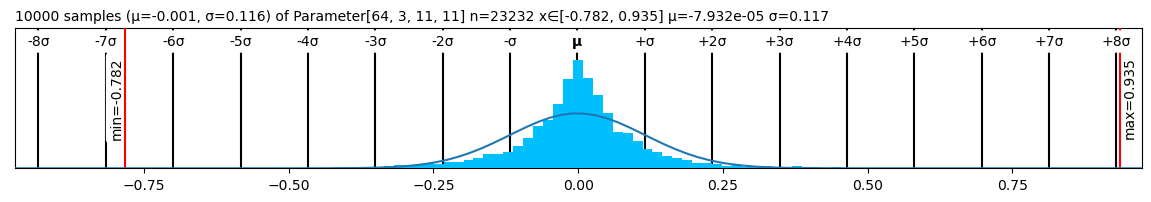

In [ ]:
w1 = f[0].weight
w1.plt

In [ ]:
# |exports
def sigmas(x: torch.Tensor, n=3):
    x /= x.std()*n*2 # *2 because I want +/- n sigmas
    return x - x.mean() + 0.5

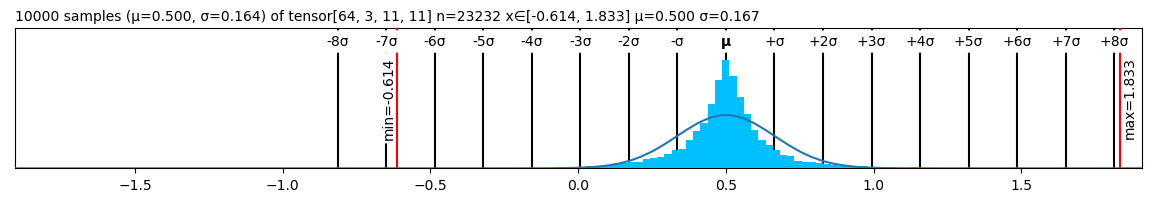

In [ ]:
sigmas(w1).plt

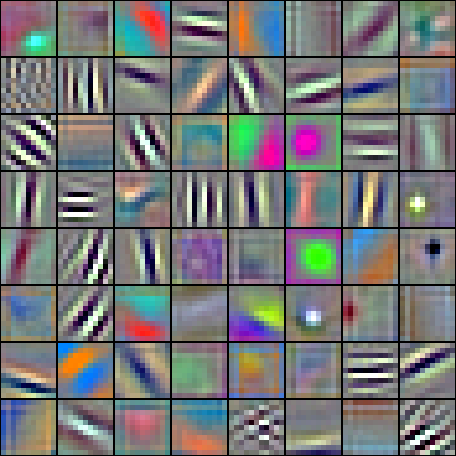

In [ ]:
sigmas(w1).clip(0, 1).rgb(gutter_px=0, scale=5)

### Explore the activations

#### Hook into activations


- Attach a hook that saves every modules input and output
- Run 1 image through the model to save in/out values for every layer.

In [ ]:
#| exports

def save_hook(m: nn.Module, i: Tuple[torch.Tensor], o: torch.Tensor):
    m.inp = i[0] # torch passses a tuple because that's how forward() works in general.
    m.out = o

for l in f:
    if not hasattr(l, "hooked"):
        l.register_forward_hook(save_hook)
        l.hooked=True

f(image[None]) # Outputs 6x6x256 feature map, but we only care about the layer activations.

tensor[1, 256, 6, 6] n=9216 x∈[0., 24.330] μ=0.619 σ=1.803

- Layer activations

In [ ]:
#| exports
for i, l in enumerate(f):
    print(f"{i}: {l}")
    if not i: print(f"\tIn:  {l.inp}") # For other layers, input=previous layers output.
    print(f"\tOut: {l.out}")

0: Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
	In:  tensor[1, 3, 224, 224] n=150528 x∈[-2.101, 2.640] μ=0.125 σ=1.512
	Out: tensor[1, 64, 55, 55] n=193600 x∈[-34.649, 32.174] μ=-0.398 σ=3.305
1: ReLU()
	Out: tensor[1, 64, 55, 55] n=193600 x∈[0., 32.174] μ=0.718 σ=1.886
2: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
	Out: tensor[1, 64, 27, 27] n=46656 x∈[0., 32.174] μ=1.977 σ=2.887
3: Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
	Out: tensor[1, 192, 27, 27] n=139968 x∈[-168.725, 60.178] μ=-9.465 σ=13.468
4: ReLU()
	Out: tensor[1, 192, 27, 27] n=139968 x∈[0., 60.178] μ=0.836 σ=2.859
5: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
	Out: tensor[1, 192, 13, 13] n=32448 x∈[0., 60.178] μ=2.660 σ=4.923
6: Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	Out: tensor[1, 384, 13, 13] n=64896 x∈[-93.757, 47.511] μ=-13.378 σ=14.596
7: ReLU()
	Out: tensor[1, 384, 13, 13] n=6

#### Explore the first Conv block (Conv-ReLu-MaxPool)

In [ ]:
#| exports
pool_idxs = [ i for i in range(len(f)) if isinstance(f[i], nn.MaxPool2d) ]
pool_idxs

[2, 5, 12]

In [ ]:
c1 = f[pool_idxs[0]-2] # Conv  1
r1 = f[pool_idxs[0]-1] # ReLU  1
m1 = f[pool_idxs[0]] # MaxPool 1

Convolution input

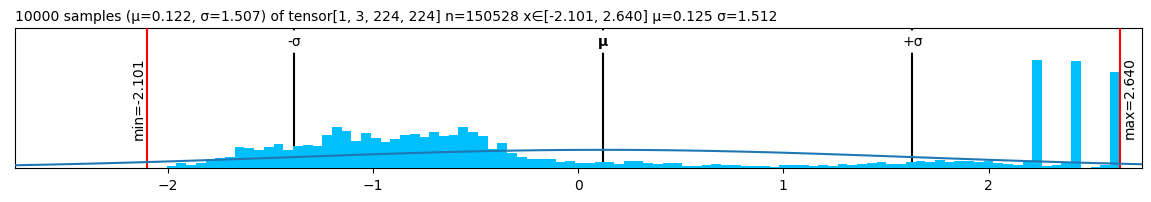

In [ ]:
c1.inp.plt

Note the 3 pillars on the right. It's the white margins that are part of the image.\
R, G and B channels are normalized with slightly different values, so you see 3 pillars\
instead of one at max.

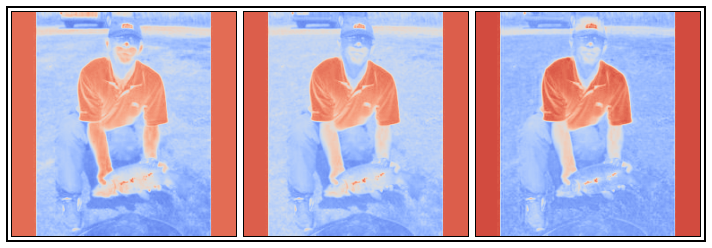

In [ ]:
sigmas(c1.inp, 2).chans

Convolution output

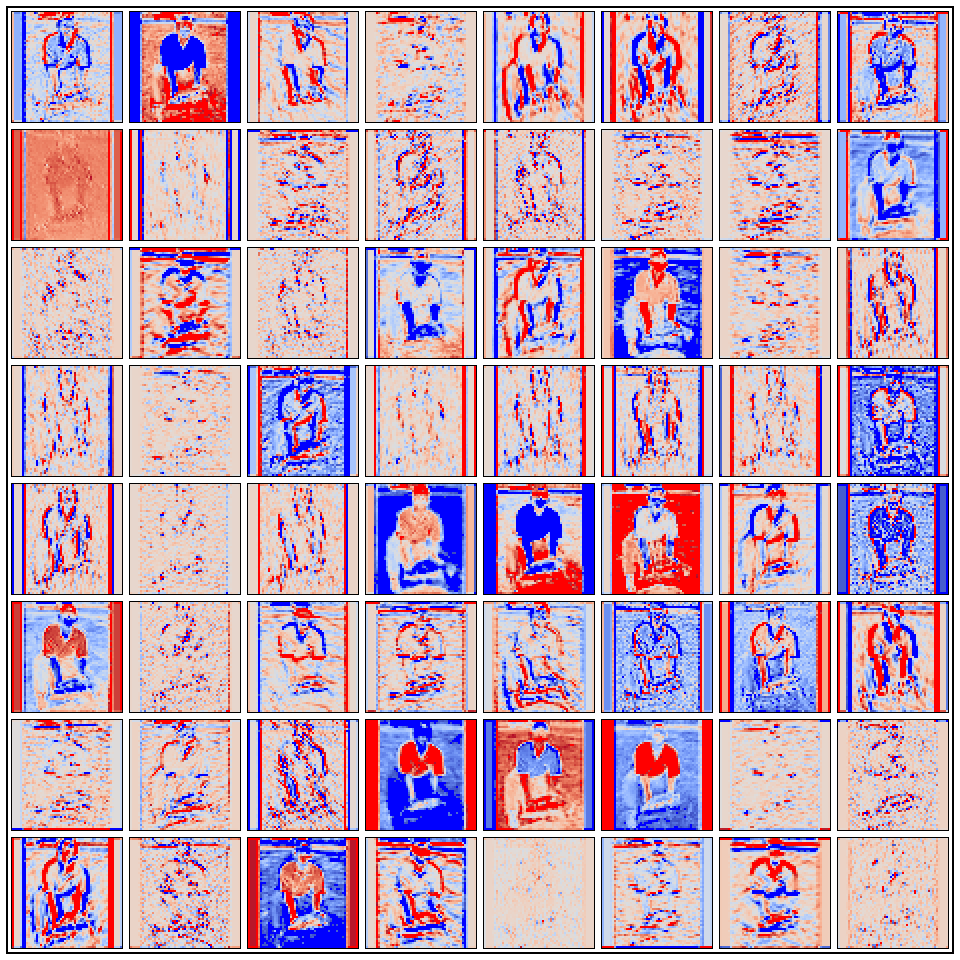

In [ ]:
sigmas(c1.out, n=1).chans(scale=2)

I see a lot of edge detectors, and a bunch of other things.

In [ ]:
# |exports

def pos_sigmas(x: torch.Tensor, n=2):
    "Give n an input of non-negative numbers, rescale it fit nσ into [0..1] range"
    return x / (n * (x[ x> 0 ].std()))

ReLu output

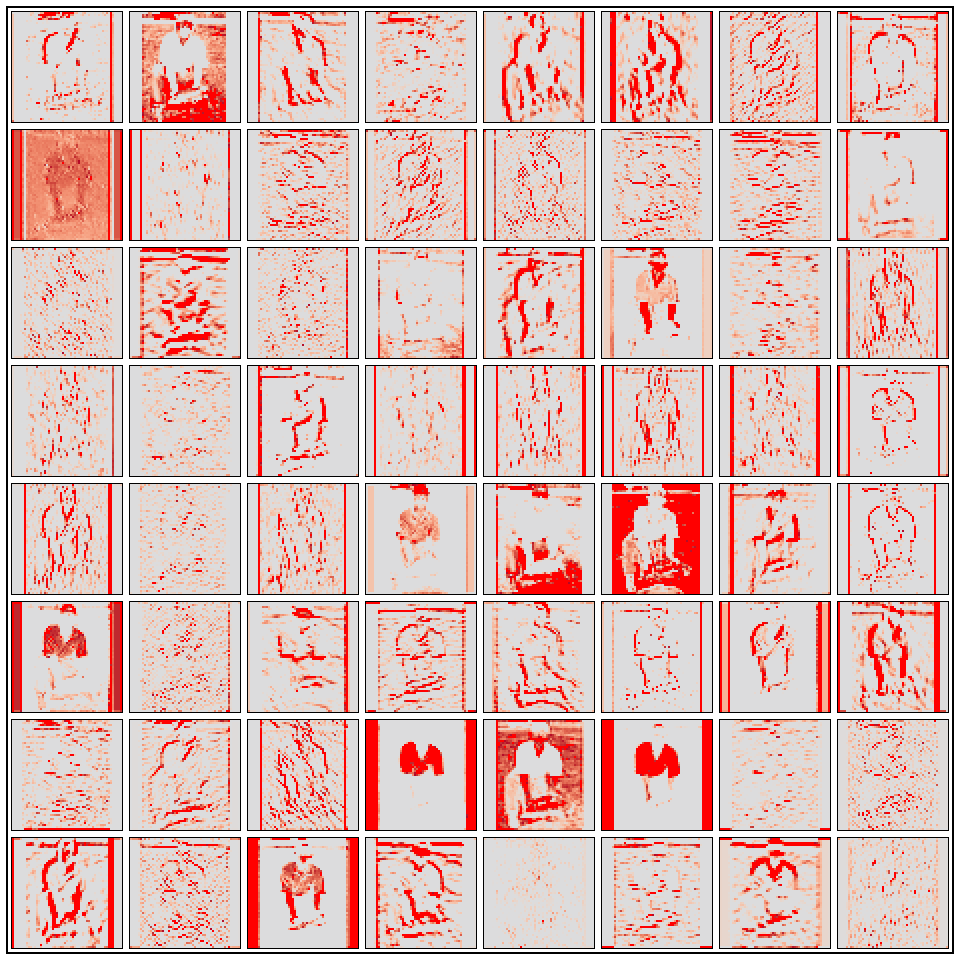

In [ ]:
(pos_sigmas(r1.out, n=2) + 0.5).chans(scale=2)

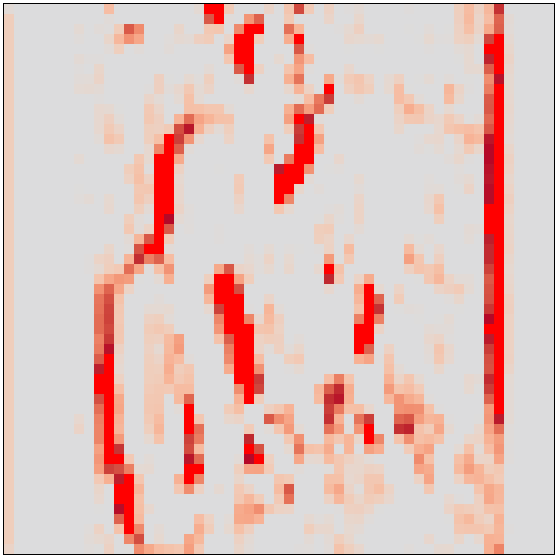

In [ ]:
(pos_sigmas(r1.out[0,4,:], n=4) + 0.5).chans(scale=10) # A wide edge detector

After MaxPool. Note that a lot fewer pixels are zero / close to zero.

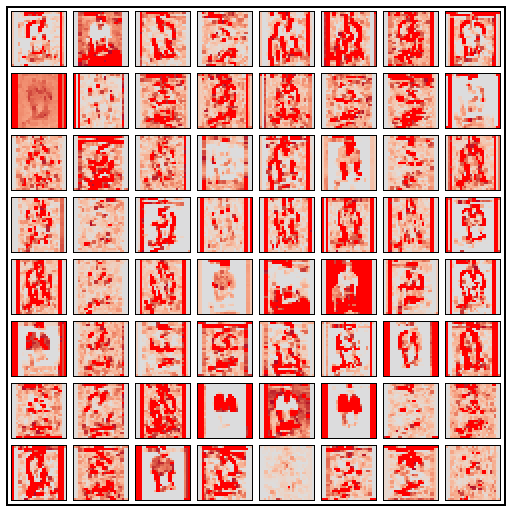

In [ ]:
(pos_sigmas(m1.out, n=2) + 0.5).chans(scale=2)

### DeconvNet

- Get the indices of the values that went through MaxPool

In [ ]:
idx_max_pool2d = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)
_, m1_switch = idx_max_pool2d(m1.inp) # Returns tuple (maxs, max_idxs)
m1_switch

tensor[1, 64, 27, 27] n=46656 x∈[0., 3.024e+03] μ=1.499e+03 σ=859.119 i64

In [ ]:
torch.set_printoptions(linewidth=120)
m1_switch[0,0,:16,:16].v # Top left corner

tensor[16, 16] n=256 x∈[2.000, 1.792e+03] μ=873.312 σ=510.421 i64
tensor([[  55,    2,    4,   63,   64,   10,   69,  125,   17,   20,   20,   23,   26,   26,   29,   30],
        [ 110,  112,  114,  227,  229,  177,  179,  125,  126,  183,  187,  187,  134,  137,  138,  141],
        [ 220,  222,  224,  227,  229,  287,  287,  290,  237,  293,  242,  242,  244,  246,  248,  307],
        [ 330,  332,  334,  448,  449,  340,  342,  456,  457,  348,  350,  352,  466,  467,  468,  472],
        [ 440,  442,  444,  448,  449,  450,  509,  510,  511,  570,  572,  572,  576,  576,  580,  527],
        [ 550,  552,  554,  668,  668,  671,  672,  675,  678,  624,  572,  572,  576,  576,  635,  635],
        [ 660,  662,  664,  777,  668,  671,  672,  786,  678,  678,  680,  682,  684,  686,  745,  745],
        [ 770,  772,  774,  777,  778,  780,  839,  786,  786,  788,  790,  792,  794,  908,  908,  800],
        [ 880,  882,  884,  998,  998, 1001, 1004,  896,  896,  898,  900,  902,  904,

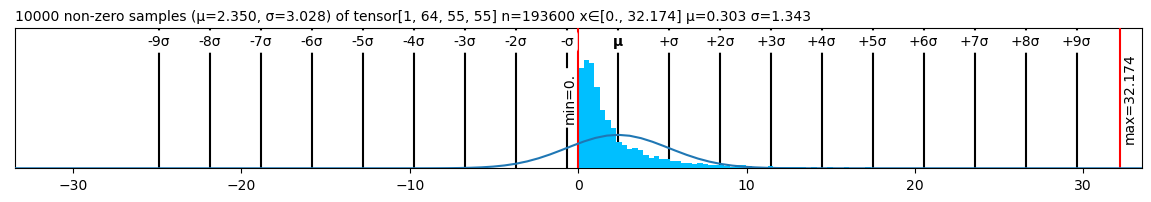

In [ ]:
unpool_2d = nn.MaxUnpool2d(kernel_size=3, stride=2)
unpooled_m1_inp = unpool_2d(m1.out, m1_switch)
unpooled_m1_inp.plt(plt0=0)

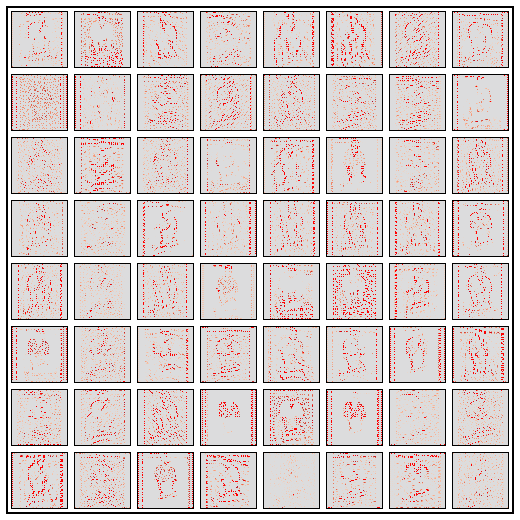

In [ ]:
(pos_sigmas(unpooled_m1_inp, n=2)+0.5).chans

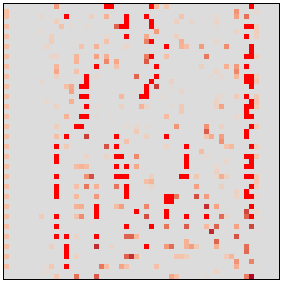

In [ ]:
(pos_sigmas(unpooled_m1_inp[0,4]) + 0.5).chans(scale=5)

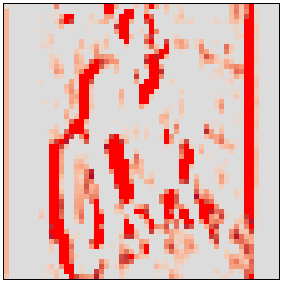

In [ ]:
(pos_sigmas(m1.inp[0,4]) + 0.5).chans(scale=5)

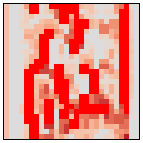

In [ ]:
(pos_sigmas(m1.out[0,4]) + 0.5).chans(scale=5)

In [ ]:
(idx_max_pool2d(unpooled_m1_inp)[0] == m1.out).all().item()

True

I seems to work. It looks a bit sparse because the Pool kernel=2 and stride=2.\
If an input pixel has a high activation, it will zero out all pixels in a 5x5 pixel square.

In [ ]:

nn.MaxUnpool2d



torch.nn.modules.pooling.MaxUnpool2d

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()